Installation of specific packages

In [1]:
%pip install mne
%pip install PyWavelets
%pip install networkx

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Loading necessary libraries

In [2]:
import pandas as pd
import mne 
import numpy as np
import os
import matplotlib.pyplot as plt 
import pywt
import networkx

Main function for EEG analysis

In [3]:
def load_and_filter(data):

   raw = mne.io.read_raw_brainvision(data, preload=True)
   ch_names = ['Aux1', 'B2+', 'B3+', 'B1+'] #экг электрод отдельно будет анализирован
   raw.drop_channels(ch_names)
   mapping = {'Po3': 'PO3', 'Po4': 'PO4'}
   raw.rename_channels(mapping)
   raw.set_eeg_reference()
   '''info, times = raw[:, :]
   coeffs = []
   for channel_data in info:
      channel_coeffs = pywt.wavedec(channel_data, 'bior2.6', level=6)
      coeffs.append(channel_coeffs)
   reconstructed_data = []
   for channel_coeffs in coeffs:
      reconstructed_channel = pywt.waverec(channel_coeffs, 'bior2.6')
      reconstructed_data.append(reconstructed_channel)
   reconstructed_data = np.array(reconstructed_data)
   annot = raw.info
   reconstructed_raw = mne.io.RawArray(reconstructed_data, annot)
   reconstructed_raw.set_annotations(raw.annotations)'''
   reconstructed_raw = raw
   reconstructed_raw.notch_filter(freqs=[50,100,150,200]) #можно другие попробовать но вроде это дефолт
   reconstructed_raw.filter(l_freq=1, h_freq=40) #можно взять верхний порог повыше но так пойдет
   reconstructed_raw.set_montage('standard_1020')
   events, ev_ids = mne.events_from_annotations(reconstructed_raw)
   zapahs = {'ZAPAH':10003}
   epochs = mne.Epochs(reconstructed_raw, events = events,
                event_id=zapahs,
                tmin=-0.1, #интервал от -0.2 до +0.6 от момента нажатия на пробел
                tmax=1.5,
                baseline=(-0.1, 0),)
   return epochs

# wavelet filtering function which can be used for analysis of the data but not for EEGNET fit
def wavelet_filter_epochs(epochs, wavelet='bior2.6', level=6):

    
    epochs_data = epochs.get_data()  # shape: (n_epochs, n_channels, n_times)

    filtered_data = []


    for epoch in epochs_data:
        filtered_epoch = []

        for channel_data in epoch:
            
            coeffs = pywt.wavedec(channel_data, wavelet, level=level)

            filtered_channel = pywt.waverec(coeffs, wavelet)

            filtered_epoch.append(filtered_channel[:len(channel_data)])  


        filtered_data.append(filtered_epoch)

    filtered_data = np.array(filtered_data)

    info = epochs.info
    filtered_epochs = mne.EpochsArray(filtered_data, info, events=epochs.events,
                                      tmin=epochs.tmin, event_id=epochs.event_id)
    #evoked = filtered_epochs.average()
    return filtered_epochs

In [ ]:
#ВЫБОР ФАЙЛА НА АНАЛИЗ
data = '/content/drive/MyDrive/Aroma_project/NeoRec_2024-10-09_17-32-43.vhdr'

In [ ]:
upd_data = load_and_filter(data) #первая функция
upd_data.plot()

In [ ]:
#хитрый ica с гиперпараметрами накрученными
from mne.preprocessing import ICA
ica = ICA(n_components=0.99, max_iter='auto', random_state=42, verbose=False)
#дефолтный ica, убери коммент (символ #), если захочешь именно его юзать
#ica = mne.preprocessing.ICA(random_state=42)
ica.fit(upd_data, verbose=False)
ica.plot_components()
plt.show()
ica

In [ ]:
upd_data.plot_psd();

In [6]:
#ФУНКЦИИ ДЛЯ РАЗДЕЛЕНИЯ ПО ПРИЯТНОСТИ

def classify_smell(rating):
    if rating in [9, 10]:
        return 'great'
    elif rating in [7, 8]:
        return 'good'
    elif rating in [5, 6]:
        return 'neutral'
    elif rating in [3, 4]:
        return 'bad'
    elif rating in [1, 2]:
        return 'atrocious'
    return None


def split_epochs_by_smell_class(data, respondent_number):

    respondent_data = data[data['№'].fillna(method='ffill') == respondent_number]

    epochs = {'great': [], 'good': [], 'neutral': [], 'bad': [], 'atrocious': []}

    epoch_counter = 1

    for index, row in respondent_data.iterrows():
        rating = row['Приятность']
        smell_class = classify_smell(rating)

        if smell_class:

            epochs[smell_class].extend(list(range(epoch_counter, epoch_counter + 4)))
            epoch_counter += 4

    return epochs

In [7]:
def average_epochs_by_class(epochs, epoch_split, respondent_number):
    averaged_epochs = {}

    '''# Check that the input is an MNE Epochs object
    if not isinstance(epochs, mne.Epochs):
        raise TypeError("The input 'epochs' must be an instance of 'mne.Epochs'.")'''

    for smell_class, epoch_indices in epoch_split.items():
        if epoch_indices:

            zero_based_indices = [i - 1 for i in epoch_indices]

            selected_epochs = epochs[zero_based_indices]

            averaged_epochs[smell_class] = selected_epochs.average()

            file_name = f'respondent_{respondent_number}_{smell_class}_smell-ave.fif'

            averaged_epochs[smell_class].save(file_name)
            print(f"Saved: {file_name}")

    return averaged_epochs


def split_epochs_by_class(epochs, epoch_split, respondent_number):
    split_epochs = {}

    for smell_class, epoch_indices in epoch_split.items():
        if epoch_indices:

            zero_based_indices = [i - 1 for i in epoch_indices]

            selected_epochs = epochs[zero_based_indices]

            file_name = f'respondent_{respondent_number}_{smell_class}_smell-epo.fif'
            selected_epochs.save(file_name)
            print(f"Saved: {file_name}")

            split_epochs[smell_class] = selected_epochs

    return split_epochs

In [8]:
def plot_rhythms(evoked, file_prefix):

    rhythms = {
        'theta': (4, 8),
        'alpha': (8, 12),
        'beta': (12, 30),
        'gamma': (30, 100)
    }

    for rhythm, (fmin, fmax) in rhythms.items():
        print(f'Creating plots for {rhythm} rhythm ({fmin}-{fmax} Hz)...')

        # Apply band-pass filter for the current rhythm
        filtered_evoked = evoked.copy().filter(fmin, fmax)

        # Time-domain plot
        filtered_evoked.plot()
        plt.suptitle(f'{rhythm.capitalize()} rhythm ({fmin}-{fmax} Hz)')
        plt.show()

        # Power Spectral Density (PSD) plot
        filtered_evoked.plot_psd(fmin=fmin, fmax=fmax)
        plt.suptitle(f'{rhythm.capitalize()} rhythm PSD ({fmin}-{fmax} Hz)')
        plt.show()

        # Joint plot (combination of topography and evoked response)
        filtered_evoked.plot_joint()
        plt.suptitle(f'{rhythm.capitalize()} rhythm Joint Plot ({fmin}-{fmax} Hz)')
        plt.show()

Скипаем предобработку и переходим сразу к анализу фифов

In [9]:
neutral_smells = mne.read_epochs('combined_neutral_smells-epo.fif')
good_smells = mne.read_epochs('combined_good_smells-epo.fif')
bad_smells = mne.read_epochs('combined_bad_smells-epo.fif')
great_smells = mne.read_epochs('combined_great_smells-epo.fif')
atrocious_smells = mne.read_epochs('combined_atrocious_smells-epo.fif')

Reading c:\Users\Леонид\Desktop\olfactory\combined_neutral_smells-epo.fif ...
    Found the data of interest:
        t =    -100.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
208 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\Леонид\Desktop\olfactory\combined_good_smells-epo.fif ...
    Found the data of interest:
        t =    -100.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
136 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\Леонид\Desktop\olfactory\combined_bad_smells-epo.fif ...
    Found the data of interest:
        t =    -100.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
120 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\Леонид\Desktop\olfactory\combined_great_smells-epo.fif ...
    Found the data 

In [10]:
%pip install tensorflow keras mne scikit-learn matplotlib pyRiemann

INFO: pip is looking at multiple versions of contourpy to determine which version is compatible with other requirements. This could take a while.
   ---------------------------------------- 0.0/376.0 MB ? eta -:--:--
   ---------------------------------------- 0.8/376.0 MB 5.6 MB/s eta 0:01:07
   ---------------------------------------- 2.1/376.0 MB 7.8 MB/s eta 0:00:48
    --------------------------------------- 5.0/376.0 MB 8.9 MB/s eta 0:00:42
    --------------------------------------- 5.0/376.0 MB 8.9 MB/s eta 0:00:42
    --------------------------------------- 9.2/376.0 MB 9.4 MB/s eta 0:00:40
   - -------------------------------------- 11.3/376.0 MB 9.5 MB/s eta 0:00:39
   - -------------------------------------- 13.4/376.0 MB 9.6 MB/s eta 0:00:38
   - -------------------------------------- 14.7/376.0 MB 9.1 MB/s eta 0:00:40
   - -------------------------------------- 17.0/376.0 MB 9.3 MB/s eta 0:00:39
   -- ------------------------------------- 19.1/376.0 MB 9.4 MB/s eta 0:00:3

  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
catboost 1.2.7 requires numpy<2.0,>=1.16.0, but you have numpy 2.1.3 which is incompatible.
colabfold 1.5.4 requires importlib-metadata<5.0.0,>=4.8.2, but you have importlib-metadata 8.6.1 which is incompatible.
colabfold 1.5.4 requires numpy<2.0.0,>=1.21.6, but you have numpy 2.1.3 which is incompatible.
tensorflow-intel 2.18.0 requires ml-dtypes<0.5.0,>=0.4.0, but you have ml-dtypes 0.5.1 which is incompatible.
tensorflow-intel 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.1.3 which is incompatible.
tensorflow-intel 2.18.0 requires tensorboard<2.19,>=2.18, but you have tensorboard 2.19.0 which is incompatible.
torchvision 0.19.0 requires numpy<2, but you have numpy 2.1.3 which is incompatible.

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice]

In [12]:
!git clone https://github.com/vlawhern/arl-eegmodels

Cloning into 'arl-eegmodels'...


In [13]:
import numpy as np
from sklearn.feature_selection import mutual_info_regression
# Assume 'mne' is installed and your Epochs objects are created
# e.g., good_smells, bad_smells, etc.

# --- 1. SETUP AS PER THE PAPER ---

# As per Section 3.1.1, the paper uses five frequency bands.
# δ (0–4 Hz), θ (4–7 Hz), α (7–13 Hz), β (13–30 Hz), and γ (30–45 Hz)
frequency_bands = {
    'delta': (0.5, 4.), # Note: 0 Hz is DC offset, so 0.5 is a practical start
    'theta': (4., 7.),
    'alpha': (7., 13.),
    'beta': (13., 30.),
    'gamma': (30., 45.)
}

# As per Section 3.1.2, the paper uses nine proportional thresholds.
proportional_thresholds = [10, 20, 30, 40, 50, 60, 70, 80, 90]


# --- 2. HELPER FUNCTIONS (Your originals, slightly adapted) ---

def filter_epochs(epochs, fmin, fmax):
    # This assumes 'epochs' is an MNE Epochs object
    return epochs.filter(fmin, fmax, fir_design='firwin', verbose=False)

def filter_smell_epochs(smell_epochs, bands):
    filtered_epochs = {}
    for band, (fmin, fmax) in bands.items():
        filtered_epochs[band] = filter_epochs(smell_epochs.copy(), fmin, fmax)
    return filtered_epochs

def compute_mutual_information(X, Y):
    # Reshape is needed for scikit-learn's mutual_info_regression
    mi = mutual_info_regression(X.reshape(-1, 1), Y.ravel())
    return mi[0]

def compute_mi_connectivity(epochs):
    data = epochs.get_data(copy=False)  # Shape: (n_epochs, n_channels, n_times)
    n_channels = data.shape[1]
    mi_matrix = np.zeros((n_channels, n_channels))

    # Compute MI between all pairs of channels, averaged over epochs
    for i in range(n_channels):
        for j in range(i + 1, n_channels):
            # Calculate MI for each epoch and then average
            mi_values = [compute_mutual_information(data[epoch, i, :], data[epoch, j, :]) for epoch in range(data.shape[0])]
            mean_mi = np.mean(mi_values)
            mi_matrix[i, j] = mean_mi
            mi_matrix[j, i] = mean_mi # Symmetric matrix
    return mi_matrix

# --- 3. NEW PROPORTIONAL THRESHOLDING FUNCTION ---

def apply_proportional_threshold(connectivity_matrix, threshold_percentage):
    """
    Applies a proportional threshold to a connectivity matrix to create a binary network.

    As described in the paper (Sections 2.2.3 and 3.1.2), this method keeps a
    fixed percentage of the strongest connections.

    Args:
        connectivity_matrix (np.ndarray): A symmetric matrix of connection strengths (e.g., MI).
        threshold_percentage (float): The percentage of connections to keep (e.g., 10 for 10%).

    Returns:
        np.ndarray: A binary adjacency matrix where 1 represents a connection and 0 represents no connection.
    """
    if not (0 < threshold_percentage <= 100):
        raise ValueError("threshold_percentage must be between 0 and 100.")

    matrix = connectivity_matrix.copy()
    np.fill_diagonal(matrix, 0)
    
    upper_triangle_indices = np.triu_indices_from(matrix, k=1)
    connection_values = matrix[upper_triangle_indices]

    if threshold_percentage == 100:
        threshold_value = np.min(connection_values[connection_values > 0]) - 1e-9
    else:
        threshold_value = np.percentile(connection_values, 100 - threshold_percentage)

    binary_matrix = (matrix >= threshold_value).astype(int)
    return binary_matrix

# --- 4. MAIN PROCESSING WORKFLOW ---

def create_functional_networks(epochs_object, bands, thresholds):
    """
    Full pipeline to create multiple functional brain networks for a given condition.
    
    Returns a nested dictionary: {band: {threshold: binary_matrix}}
    """
    # Step 1: Filter data into frequency bands
    filtered_epochs_by_band = filter_smell_epochs(epochs_object, bands)
    
    all_networks = {}
    
    for band_name, filtered_epochs in filtered_epochs_by_band.items():
        # Step 2: Compute the MI correlation matrix for the band
        mi_matrix = compute_mi_connectivity(filtered_epochs)
        
        all_networks[band_name] = {}
        
        # Step 3: Apply multiple proportional thresholds to create binary networks
        for p_thresh in thresholds:
            binary_network = apply_proportional_threshold(mi_matrix, p_thresh)
            all_networks[band_name][p_thresh] = binary_network
            
    return all_networks

# --- EXAMPLE USAGE ---
# Assuming you have your MNE Epochs objects loaded:
# good_smells, bad_smells, neutral_smells, great_smells, atrocious_smells

# print("Creating functional networks for 'Good Smells'...")
# networks_good = create_functional_networks(good_smells, frequency_bands, proportional_thresholds)

# print("Creating functional networks for 'Bad Smells'...")
# networks_bad = create_functional_networks(bad_smells, frequency_bands, proportional_thresholds)

# ... and so on for your other conditions

# You can now access a specific network like this:
# Example: Get the 20% density network for the alpha band under the 'good smells' condition
# alpha_network_20_percent = networks_good['alpha'][20]

# print("\nExample: Shape of the alpha band network at 20% threshold for 'Good Smells':")
# print(alpha_network_20_percent.shape)
# print("This is a binary matrix:")
# print(alpha_network_20_percent)

In [14]:
import numpy as np
import networkx as nx

# --- 1. SETUP - These must match the network generation step ---

# The order is critical for creating consistent feature vectors
ORDERED_BANDS = ['delta', 'theta', 'alpha', 'beta', 'gamma']
ORDERED_THRESHOLDS = [10, 20, 30, 40, 50, 60, 70, 80, 90]

# --- 2. HELPER FUNCTION TO GET PROPERTIES FROM ONE NETWORK ---

def extract_network_properties(binary_network):
    """
    Calculates the four specified network properties for a single binary network.
    
    Args:
        binary_network (np.ndarray): A binary adjacency matrix.
        
    Returns:
        tuple: A tuple containing four dictionaries (clustering, degree, betweenness, local_eff),
               where each dictionary maps node index to its property value.
    """
    G = nx.from_numpy_array(binary_network)
    
    if not G.nodes:
        # Handle empty graph case
        return {}, {}, {}, {}
        
    # As per Section 2.2.4 of the paper, we extract four local properties
    clustering_coeffs = nx.clustering(G)
    degrees = dict(G.degree())
    betweenness_centralities = nx.betweenness_centrality(G)
    
    # The paper's "local efficiency" is the efficiency of the subnetwork around each node.
    # This is commonly interpreted as the global efficiency of the ego-graph (node + neighbors).
    local_efficiencies = {}
    for node in G.nodes():
        neighbors = list(G.neighbors(node))
        # Create the subgraph induced by the node and its immediate neighbors
        ego_graph = G.subgraph([node] + neighbors)
        # The efficiency of a graph with 0 or 1 node is 0.
        if len(ego_graph.nodes()) < 2:
            local_efficiencies[node] = 0.0
        else:
            local_efficiencies[node] = nx.global_efficiency(ego_graph)
            
    return clustering_coeffs, degrees, betweenness_centralities, local_efficiencies

# --- 3. MAIN FUNCTION TO CREATE THE LARGE FEATURE VECTORS ---

def create_feature_vectors_for_sample(all_networks_for_sample):
    """
    Creates the large, concatenated feature vectors for a single EEG sample
    (e.g., one trial), as described in the paper.

    Args:
        all_networks_for_sample (dict): The nested dictionary {band: {threshold: matrix}}
                                        for a single sample.

    Returns:
        dict: A dictionary containing the four flattened feature vectors.
              e.g., {'degree': np.array([...]), 'clustering': np.array([...])}
              Each array will have a shape of (945,) for a 21-channel setup.
    """
    # Initialize lists to hold the concatenated values for each property type
    feature_lists = {
        'clustering': [],
        'degree': [],
        'betweenness': [],
        'local_efficiency': []
    }
    
    # Iterate through bands and thresholds in a fixed order to ensure consistency
    for band_name in ORDERED_BANDS:
        for threshold in ORDERED_THRESHOLDS:
            binary_network = all_networks_for_sample[band_name][threshold]
            
            # Get the four property dictionaries for this specific network
            clustering, degree, betweenness, local_eff = extract_network_properties(binary_network)
            
            # Ensure we have a value for every channel, even if a node becomes isolated
            num_channels = binary_network.shape[0]
            
            # Extract values in the order of node index (0, 1, 2, ...)
            # The .get(node, 0) handles cases where a node might be absent from a metric dict (unlikely but safe)
            clustering_vals = [clustering.get(node, 0) for node in range(num_channels)]
            degree_vals = [degree.get(node, 0) for node in range(num_channels)]
            betweenness_vals = [betweenness.get(node, 0) for node in range(num_channels)]
            local_eff_vals = [local_eff.get(node, 0) for node in range(num_channels)]

            # Append the list of per-node values to the master lists
            feature_lists['clustering'].extend(clustering_vals)
            feature_lists['degree'].extend(degree_vals)
            feature_lists['betweenness'].extend(betweenness_vals)
            feature_lists['local_efficiency'].extend(local_eff_vals)

    # Convert the final lists to numpy arrays
    feature_vectors = {key: np.array(value) for key, value in feature_lists.items()}
    
    return feature_vectors

# --- 4. EXAMPLE USAGE ---
# This assumes you have already run the network generation code from the previous step.
# Let's imagine 'networks_good' is the result for a *single trial* of a "good smell".
# In reality, you would loop through each trial in your Epochs object.

# Let's simulate the network dictionary for one sample (one trial)
# In your real code, this would come from your 'create_functional_networks' function
# applied to a single epoch, e.g., create_functional_networks(good_smells[0], ...)
num_channels = 21 # As per the paper
simulated_networks_for_one_sample = {
    band: {
        thresh: np.random.randint(0, 2, size=(num_channels, num_channels))
        for thresh in ORDERED_THRESHOLDS
    }
    for band in ORDERED_BANDS
}

# Now, extract the four feature vectors for this single sample
feature_vectors = create_feature_vectors_for_sample(simulated_networks_for_one_sample)

# --- Print the results to verify ---
print("Feature extraction complete for one sample.")
print("The final output is a dictionary with four feature vectors:")
print(f"Keys: {list(feature_vectors.keys())}\n")

for feature_name, vector in feature_vectors.items():
    print(f"Shape of '{feature_name}' vector: {vector.shape}")
    
# The shape should be (945,) because 5 bands * 9 thresholds * 21 channels = 945
expected_size = len(ORDERED_BANDS) * len(ORDERED_THRESHOLDS) * num_channels
print(f"\nExpected feature vector size: {expected_size}")

# To build your full dataset for machine learning, you would run this for every trial.
# For example, if you have 160 trials in total:
# all_degree_features = np.zeros((160, 945))
# all_clustering_features = np.zeros((160, 945))
# ... and so on.
# Then you loop through trials 0 to 159, run the functions, and fill each row.

Feature extraction complete for one sample.
The final output is a dictionary with four feature vectors:
Keys: ['clustering', 'degree', 'betweenness', 'local_efficiency']

Shape of 'clustering' vector: (945,)
Shape of 'degree' vector: (945,)
Shape of 'betweenness' vector: (945,)
Shape of 'local_efficiency' vector: (945,)

Expected feature vector size: 945


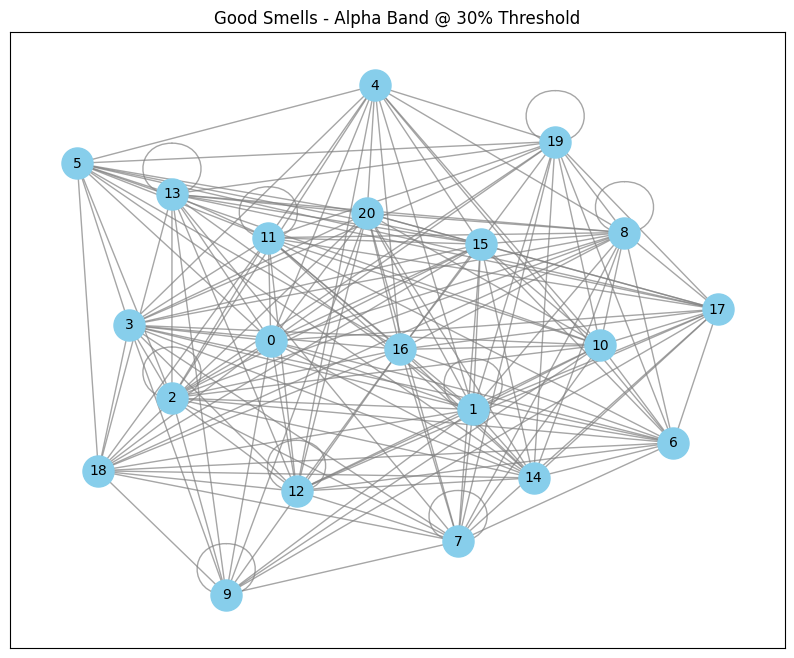

In [16]:
# --- EXAMPLE USAGE FOR A SINGLE PLOT ---

# First, let's simulate the network data for one condition (e.g., 'good smells')
# This would be the output from your 'create_functional_networks' function.
ORDERED_BANDS = ['delta', 'theta', 'alpha', 'beta', 'gamma']
ORDERED_THRESHOLDS = [10, 20, 30, 40, 50, 60, 70, 80, 90]
num_channels = 21

networks_good = {
    band: {
        thresh: np.random.randint(0, 2, size=(num_channels, num_channels))
        for thresh in ORDERED_THRESHOLDS
    }
    for band in ORDERED_BANDS
}

# Select the specific network you want to visualize
band_to_plot = 'alpha'
threshold_to_plot = 30 # Plot the network with 30% strongest connections
network_to_plot = networks_good[band_to_plot][threshold_to_plot]

# Now, call your visualization function
plot_title = f"Good Smells - {band_to_plot.capitalize()} Band @ {threshold_to_plot}% Threshold"
node_positions = visualize_connectivity(network_to_plot, title=plot_title)

In [15]:
def visualize_connectivity(connectivity_matrix, title='Connectivity Map', pos=None):
    """
    Visualize a connectivity matrix as a network graph.
    """
    # Create a graph from the connectivity matrix
    G = nx.from_numpy_array(connectivity_matrix)

    # Set positions for nodes if provided, otherwise use a spring layout
    if pos is None:
        pos = nx.spring_layout(G, seed=42)  # Layout for consistent graph visualization

    # Draw the graph
    plt.figure(figsize=(10, 8))
    nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=500)
    nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.7)
    nx.draw_networkx_labels(G, pos, font_size=10, font_color='black')

    # Add a title and display the graph
    plt.title(title)
    plt.show()

# Example usage for one frequency band and one smell class:
visualize_connectivity(thresh_mi_good['alpha'], title='Connectivity Map for Good Smells - Alpha Band')

NameError: name 'thresh_mi_good' is not defined

In [1]:
import mne
import numpy as np
import networkx as nx
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_selection import mutual_info_regression
from tqdm import tqdm # For a nice progress bar

# --- 0. SETUP AND CONSTANTS ---
print("Setting up constants and helper functions...")

# Constants for network construction, ensuring consistency
ORDERED_BANDS = {'delta': (0.5, 4.), 'theta': (4., 7.), 'alpha': (7., 13.), 'beta': (13., 30.), 'gamma': (30., 45.)}
ORDERED_THRESHOLDS = [10, 20, 30, 40, 50, 60, 70, 80, 90]


# --- 1. CORE PROCESSING FUNCTIONS (from previous steps) ---

# --- Network Construction Functions ---
def filter_single_epoch(epoch, fmin, fmax):
    return epoch.copy().filter(fmin, fmax, fir_design='firwin', verbose=False)

def compute_mi_connectivity_for_trial(epoch):
    data = epoch.get_data(copy=False)[0] # Shape (n_channels, n_times)
    n_channels = data.shape[0]
    mi_matrix = np.zeros((n_channels, n_channels))

    for i in range(n_channels):
        for j in range(i + 1, n_channels):
            # mutual_info_regression expects (n_samples, n_features), so we reshape
            mi = mutual_info_regression(data[i, :].reshape(-1, 1), data[j, :].ravel())[0]
            mi_matrix[i, j] = mi
            mi_matrix[j, i] = mi
    return mi_matrix

def apply_proportional_threshold(matrix, percentage):
    matrix = matrix.copy()
    np.fill_diagonal(matrix, 0)
    upper_triangle_values = matrix[np.triu_indices_from(matrix, k=1)]
    threshold_value = np.percentile(upper_triangle_values, 100 - percentage)
    return (matrix >= threshold_value).astype(int)

def create_functional_networks(single_epoch, bands, thresholds):
    all_networks = {}
    for band_name, (fmin, fmax) in bands.items():
        filtered_trial = filter_single_epoch(single_epoch, fmin, fmax)
        mi_matrix = compute_mi_connectivity_for_trial(filtered_trial)
        all_networks[band_name] = {}
        for p_thresh in thresholds:
            all_networks[band_name][p_thresh] = apply_proportional_threshold(mi_matrix, p_thresh)
    return all_networks

# --- Feature Extraction Functions ---
def extract_network_properties(binary_network):
    G = nx.from_numpy_array(binary_network)
    if not G.nodes: return {}, {}, {}, {}
    clustering = nx.clustering(G)
    degree = dict(G.degree())
    betweenness = nx.betweenness_centrality(G)
    local_eff = {node: nx.global_efficiency(G.subgraph([node] + list(G.neighbors(node)))) for node in G.nodes()}
    return clustering, degree, betweenness, local_eff

def create_feature_vectors_for_sample(all_networks):
    feature_lists = {'clustering': [], 'degree': [], 'betweenness': [], 'local_efficiency': []}
    num_channels = list(list(all_networks.values())[0].values())[0].shape[0]

    for band_name in ORDERED_BANDS:
        for threshold in ORDERED_THRESHOLDS:
            net = all_networks[band_name][threshold]
            clus, deg, betw, leff = extract_network_properties(net)
            feature_lists['clustering'].extend([clus.get(n, 0) for n in range(num_channels)])
            feature_lists['degree'].extend([deg.get(n, 0) for n in range(num_channels)])
            feature_lists['betweenness'].extend([betw.get(n, 0) for n in range(num_channels)])
            feature_lists['local_efficiency'].extend([leff.get(n, 0) for n in range(num_channels)])
    return {key: np.array(value) for key, value in feature_lists.items()}

# --- Classification Function (ROBUST VERSION) ---
def run_svm_classification(X, y, feature_type_name, task_name, class_names=None):
    print(f"\n===== Running Classification for {task_name} using '{feature_type_name}' Features =====")

    # Step 1: Perform the train-test split first
    try:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.25, random_state=42, stratify=y
        )
    except ValueError as e:
        print(f"SKIPPING: Could not perform stratified split for '{feature_type_name}'.")
        print(f"--> Error: {e}")
        print("--> This usually means a class has only 1 member.")
        print("=" * 60)
        return

    # Step 2: Determine the correct number of CV splits based on the TRAINING data
    unique_labels, counts = np.unique(y_train, return_counts=True)
    min_class_count_in_train = np.min(counts)
    n_splits = min(3, min_class_count_in_train)

    # Step 3: Check if cross-validation is possible at all
    if n_splits < 2:
        print(f"SKIPPING GridSearchCV for '{feature_type_name}'.")
        print(f"--> The smallest class in the training set has only {min_class_count_in_train} sample(s).")
        print("--> Cross-validation requires at least 2 samples per class.")
        print("=" * 60)
        return

    # Step 4: Run GridSearchCV with the safe `n_splits` value
    pipeline = make_pipeline(StandardScaler(), SVC(kernel='rbf', random_state=42))
    param_grid = {'svc__C': [1, 10, 100], 'svc__gamma': ['scale', 0.1, 1]}

    print(f"Running GridSearchCV with cv={n_splits}...")
    grid_search = GridSearchCV(pipeline, param_grid, cv=n_splits, n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)

    print(f"Best parameters found: {grid_search.best_params_}")
    y_pred = grid_search.predict(X_test)

    print(f"\nAccuracy for {feature_type_name}: {accuracy_score(y_test, y_pred):.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names, zero_division=0))
    print("=" * 60)


# --- 2. LOAD DATA AND DEFINE LABELS ---
print("Loading MNE Epochs files...")
try:
    # --- MODIFICATION: Define labels for the 3-class task ---
    # Unpleasant: 0
    # Pleasant:   1
    # Neutral:    2
    data_to_process = [
        {'name': 'Atrocious', 'epochs': mne.read_epochs('combined_atrocious_smells-epo.fif', verbose=False), 'pleasantness_3class_label': 0},
        {'name': 'Bad',       'epochs': mne.read_epochs('combined_bad_smells-epo.fif', verbose=False), 'pleasantness_3class_label': 0},
        {'name': 'Neutral',   'epochs': mne.read_epochs('combined_neutral_smells-epo.fif', verbose=False), 'pleasantness_3class_label': 2},
        {'name': 'Good',      'epochs': mne.read_epochs('combined_good_smells-epo.fif', verbose=False), 'pleasantness_3class_label': 1},
        {'name': 'Great',     'epochs': mne.read_epochs('combined_great_smells-epo.fif', verbose=False), 'pleasantness_3class_label': 1},
    ]
except FileNotFoundError as e:
    print(f"Error: {e}. Make sure the script is in the same directory as your '-epo.fif' files.")
    exit()

# --- 3. MAIN PROCESSING LOOP: FEATURE EXTRACTION FOR ALL TRIALS ---
print("\nStarting feature extraction for all trials. This may take a while...")

# --- MODIFICATION: Initialize a new container for the 3-class task ---
features_3class_task = {'degree': [], 'clustering': [], 'betweenness': [], 'local_efficiency': []}
labels_3class_task = []

# Use tqdm for a progress bar over all trials
total_trials = sum(len(d['epochs']) for d in data_to_process)
with tqdm(total=total_trials, desc="Processing Trials") as pbar:
    for condition in data_to_process:
        epochs = condition['epochs']
        for i in range(len(epochs)):
            trial = epochs[i] # Get a single epoch/trial
            
            # This is the most time-consuming part for each trial
            networks = create_functional_networks(trial, ORDERED_BANDS, ORDERED_THRESHOLDS)
            feature_vectors = create_feature_vectors_for_sample(networks)
            
            # --- MODIFICATION: Populate the 3-class dataset ---
            # No 'if' statement needed, as we now use all conditions.
            for key in features_3class_task:
                features_3class_task[key].append(feature_vectors[key])
            labels_3class_task.append(condition['pleasantness_3class_label'])
            
            pbar.update(1)

# --- 4. CONVERT TO NUMPY ARRAYS FOR SCIKIT-LEARN ---
print("\nConverting extracted features to NumPy arrays...")

# For the new 3-Class Pleasantness Task
X_3class = {key: np.array(val) for key, val in features_3class_task.items()}
y_3class = np.array(labels_3class_task)

# Check the shape and label distribution to ensure it's correct
unique_labels, counts = np.unique(y_3class, return_counts=True)
print(f"3-Class task dataset shape (e.g., degree): {X_3class['degree'].shape}, Labels: {y_3class.shape}")
print(f"3-Class task label distribution: {dict(zip(unique_labels, counts))}")



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Anaconda\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "c:\Anaconda\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\Anaconda\Lib\site-packages\ipykernel\kernelapp.py", line 701, in start
    self.io_loop.start()
  File "c:\Anaconda\Lib\site-packages\tornado\platform\asyncio.py", line 205, in star

ImportError: 
A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.




A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Anaconda\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "c:\Anaconda\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\Anaconda\Lib\site-packages\ipykernel\kernelapp.py", line 701, in start
    self.io_loop.start()
  File "c:\Anaconda\Lib\site-packages\tornado\platform\asyncio.py", line 205, in star

ImportError: 
A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.




A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Anaconda\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "c:\Anaconda\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\Anaconda\Lib\site-packages\ipykernel\kernelapp.py", line 701, in start
    self.io_loop.start()
  File "c:\Anaconda\Lib\site-packages\tornado\platform\asyncio.py", line 205, in star

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Anaconda\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "c:\Anaconda\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\Anaconda\Lib\site-packages\ipykernel\kernelapp.py", line 701, in start
    self.io_loop.start()
  File "c:\Anaconda\Lib\site-packages\tornado\platform\asyncio.py", line 205, in star

ImportError: 
A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.



Setting up constants and helper functions...
Loading MNE Epochs files...

Starting feature extraction for all trials. This may take a while...


Processing Trials:   0%|          | 0/640 [00:00<?, ?it/s]C:\Users\Леонид\AppData\Local\Temp\ipykernel_9628\475249311.py:24: RuntimeWarning: filter_length (3301) is longer than the signal (801), distortion is likely. Reduce filter length or filter a longer signal.
  return epoch.copy().filter(fmin, fmax, fir_design='firwin', verbose=False)
C:\Users\Леонид\AppData\Local\Temp\ipykernel_9628\475249311.py:24: RuntimeWarning: filter_length (825) is longer than the signal (801), distortion is likely. Reduce filter length or filter a longer signal.
  return epoch.copy().filter(fmin, fmax, fir_design='firwin', verbose=False)
C:\Users\Леонид\AppData\Local\Temp\ipykernel_9628\475249311.py:24: RuntimeWarning: filter_length (825) is longer than the signal (801), distortion is likely. Reduce filter length or filter a longer signal.
  return epoch.copy().filter(fmin, fmax, fir_design='firwin', verbose=False)
Processing Trials:   0%|          | 1/640 [00:06<1:04:13,  6.03s/it]C:\Users\Леонид\AppData\


Converting extracted features to NumPy arrays...
3-Class task dataset shape (e.g., degree): (640, 1080), Labels: (640,)
3-Class task label distribution: {np.int64(0): np.int64(220), np.int64(1): np.int64(212), np.int64(2): np.int64(208)}


In [ ]:
import mne
import numpy as np
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm

# --- GNN Specific Imports ---
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.utils import from_scipy_sparse_matrix
from scipy.sparse import coo_matrix

# =========================================================================
#  Keep your original CORE PROCESSING FUNCTIONS (Sections 0 and 1) here
#  ... (The code you provided from line 1 to 105)
# =========================================================================

# --- 0. SETUP AND CONSTANTS ---
print("Setting up constants and helper functions...")

# Constants for network construction, ensuring consistency
ORDERED_BANDS = {'delta': (0.5, 4.), 'theta': (4., 7.), 'alpha': (7., 13.), 'beta': (13., 30.), 'gamma': (30., 45.)}
ORDERED_THRESHOLDS = [10, 20, 30, 40, 50, 60, 70, 80, 90]


# --- 1. CORE PROCESSING FUNCTIONS (from previous steps) ---

# --- Network Construction Functions ---
def filter_single_epoch(epoch, fmin, fmax):
    return epoch.copy().filter(fmin, fmax, fir_design='firwin', verbose=False)

def compute_mi_connectivity_for_trial(epoch):
    data = epoch.get_data(copy=False)[0] # Shape (n_channels, n_times)
    n_channels = data.shape[0]
    mi_matrix = np.zeros((n_channels, n_channels))

    for i in range(n_channels):
        for j in range(i + 1, n_channels):
            # mutual_info_regression expects (n_samples, n_features), so we reshape
            mi = mutual_info_regression(data[i, :].reshape(-1, 1), data[j, :].ravel())[0]
            mi_matrix[i, j] = mi
            mi_matrix[j, i] = mi
    return mi_matrix

def apply_proportional_threshold(matrix, percentage):
    matrix = matrix.copy()
    np.fill_diagonal(matrix, 0)
    upper_triangle_values = matrix[np.triu_indices_from(matrix, k=1)]
    threshold_value = np.percentile(upper_triangle_values, 100 - percentage)
    return (matrix >= threshold_value).astype(int)

def create_functional_networks(single_epoch, bands, thresholds):
    all_networks = {}
    for band_name, (fmin, fmax) in bands.items():
        filtered_trial = filter_single_epoch(single_epoch, fmin, fmax)
        mi_matrix = compute_mi_connectivity_for_trial(filtered_trial)
        all_networks[band_name] = {}
        for p_thresh in thresholds:
            all_networks[band_name][p_thresh] = apply_proportional_threshold(mi_matrix, p_thresh)
    return all_networks

# --- Feature Extraction Functions ---
def extract_network_properties(binary_network):
    G = nx.from_numpy_array(binary_network)
    if not G.nodes: return {}, {}, {}, {}
    clustering = nx.clustering(G)
    degree = dict(G.degree())
    betweenness = nx.betweenness_centrality(G)
    local_eff = {node: nx.global_efficiency(G.subgraph([node] + list(G.neighbors(node)))) for node in G.nodes()}
    return clustering, degree, betweenness, local_eff

def create_feature_vectors_for_sample(all_networks):
    feature_lists = {'clustering': [], 'degree': [], 'betweenness': [], 'local_efficiency': []}
    num_channels = list(list(all_networks.values())[0].values())[0].shape[0]

    for band_name in ORDERED_BANDS:
        for threshold in ORDERED_THRESHOLDS:
            net = all_networks[band_name][threshold]
            clus, deg, betw, leff = extract_network_properties(net)
            feature_lists['clustering'].extend([clus.get(n, 0) for n in range(num_channels)])
            feature_lists['degree'].extend([deg.get(n, 0) for n in range(num_channels)])
            feature_lists['betweenness'].extend([betw.get(n, 0) for n in range(num_channels)])
            feature_lists['local_efficiency'].extend([leff.get(n, 0) for n in range(num_channels)])
    return {key: np.array(value) for key, value in feature_lists.items()}

# --- Classification Function (ROBUST VERSION) ---
def run_svm_classification(X, y, feature_type_name, task_name, class_names=None):
    print(f"\n===== Running Classification for {task_name} using '{feature_type_name}' Features =====")

    # Step 1: Perform the train-test split first
    try:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.25, random_state=42, stratify=y
        )
    except ValueError as e:
        print(f"SKIPPING: Could not perform stratified split for '{feature_type_name}'.")
        print(f"--> Error: {e}")
        print("--> This usually means a class has only 1 member.")
        print("=" * 60)
        return

    # Step 2: Determine the correct number of CV splits based on the TRAINING data
    unique_labels, counts = np.unique(y_train, return_counts=True)
    min_class_count_in_train = np.min(counts)
    n_splits = min(3, min_class_count_in_train)

    # Step 3: Check if cross-validation is possible at all
    if n_splits < 2:
        print(f"SKIPPING GridSearchCV for '{feature_type_name}'.")
        print(f"--> The smallest class in the training set has only {min_class_count_in_train} sample(s).")
        print("--> Cross-validation requires at least 2 samples per class.")
        print("=" * 60)
        return

    # Step 4: Run GridSearchCV with the safe `n_splits` value
    pipeline = make_pipeline(StandardScaler(), SVC(kernel='rbf', random_state=42))
    param_grid = {'svc__C': [1, 10, 100], 'svc__gamma': ['scale', 0.1, 1]}

    print(f"Running GridSearchCV with cv={n_splits}...")
    grid_search = GridSearchCV(pipeline, param_grid, cv=n_splits, n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)

    print(f"Best parameters found: {grid_search.best_params_}")
    y_pred = grid_search.predict(X_test)

    print(f"\nAccuracy for {feature_type_name}: {accuracy_score(y_test, y_pred):.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names, zero_division=0))
    print("=" * 60)

# --- 2. LOAD DATA AND DEFINE LABELS (Same as before) ---
print("Loading MNE Epochs files...")
try:
    data_to_process = [
        {'name': 'Atrocious', 'epochs': mne.read_epochs('combined_atrocious_smells-epo.fif', verbose=False), 'pleasantness_3class_label': 0},
        {'name': 'Bad',       'epochs': mne.read_epochs('combined_bad_smells-epo.fif', verbose=False), 'pleasantness_3class_label': 0},
        {'name': 'Neutral',   'epochs': mne.read_epochs('combined_neutral_smells-epo.fif', verbose=False), 'pleasantness_3class_label': 2},
        {'name': 'Good',      'epochs': mne.read_epochs('combined_good_smells-epo.fif', verbose=False), 'pleasantness_3class_label': 1},
        {'name': 'Great',     'epochs': mne.read_epochs('combined_great_smells-epo.fif', verbose=False), 'pleasantness_3class_label': 1},
    ]
except FileNotFoundError as e:
    print(f"Error: {e}. Make sure the script is in the same directory as your '-epo.fif' files.")
    exit()


# --- 3. PREPARE GRAPH DATA FOR GNN ---
print("\nPreparing graph data for GNN. This may take a while...")

# A GNN takes one graph per sample. We must choose a specific band and threshold
# to create this graph. Let's start with a reasonable choice: alpha band at 50% threshold.
# You can experiment by changing these later.
TARGET_BAND = 'alpha'
TARGET_THRESHOLD = 50

graph_dataset = []
total_trials = sum(len(d['epochs']) for d in data_to_process)
with tqdm(total=total_trials, desc="Creating Graph Dataset") as pbar:
    for condition in data_to_process:
        epochs = condition['epochs']
        for i in range(len(epochs)):
            trial = epochs[i]
            
            # 1. Create all networks for the trial
            all_networks = create_functional_networks(trial, ORDERED_BANDS, ORDERED_THRESHOLDS)
            
            # 2. Select the specific adjacency matrix for our target network
            adj_matrix = all_networks[TARGET_BAND][TARGET_THRESHOLD]
            num_channels = adj_matrix.shape[0]

            # 3. Convert the adjacency matrix to PyG edge_index format
            edge_index, _ = from_scipy_sparse_matrix(coo_matrix(adj_matrix))
            
            # 4. Define Node Features. We'll use an identity matrix, so the GNN
            #    learns a representation for each channel from scratch.
            x = torch.eye(num_channels, dtype=torch.float)
            
            # 5. Get the graph label
            y = torch.tensor([condition['pleasantness_3class_label']], dtype=torch.long)
            
            # 6. Create the PyG Data object and add it to our dataset
            graph_data = Data(x=x, edge_index=edge_index, y=y)
            graph_dataset.append(graph_data)
            
            pbar.update(1)

print(f"\nDataset created with {len(graph_dataset)} graphs.")


# --- 4. DEFINE THE GRAPH NEURAL NETWORK (GNN) MODEL ---
class GCN(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        torch.manual_seed(42)
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.classifier = torch.nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)

        # 2. Readout layer to get a graph-level embedding
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        out = self.classifier(x)
        
        return out

# --- 5. TRAIN AND EVALUATE THE GNN ---
print("\nSplitting data and setting up for training...")

# Split the dataset of Graph objects
train_data, test_data = train_test_split(graph_dataset, test_size=0.25, random_state=42, stratify=[d.y.item() for d in graph_dataset])

print(f"Training samples: {len(train_data)}, Test samples: {len(test_data)}")

# Create DataLoaders for batching
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Setup model, optimizer, and loss function
num_nodes = graph_dataset[0].num_nodes
model = GCN(num_node_features=num_nodes, hidden_channels=64, num_classes=3)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

# Training function
def train():
    model.train()
    for data in train_loader:
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()

# Test function
def test(loader):
    model.eval()
    correct = 0
    all_preds = []
    all_labels = []
    for data in loader:
        out = model(data.x, data.edge_index, data.batch)
        pred = out.argmax(dim=1)
        correct += int((pred == data.y).sum())
        all_preds.extend(pred.tolist())
        all_labels.extend(data.y.tolist())
    accuracy = correct / len(loader.dataset)
    return accuracy, all_labels, all_preds

# --- Main Training Loop ---
print("\nStarting GNN Training...")
for epoch in range(1, 101):
    train()
    if epoch % 10 == 0:
        train_acc, _, _ = test(train_loader)
        test_acc, _, _ = test(test_loader)
        print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

# --- Final Evaluation ---
print("\n--- Final Model Evaluation ---")
final_accuracy, y_true, y_pred = test(test_loader)
class_names = ['Unpleasant', 'Pleasant', 'Neutral']

print(f"Final Test Accuracy: {final_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

print("\n\nAnalysis Complete.")

Setting up constants and helper functions...
Loading MNE Epochs files...

Preparing graph data for GNN. This may take a while...


Creating Graph Dataset:   0%|          | 0/640 [00:00<?, ?it/s]C:\Users\Леонид\AppData\Local\Temp\ipykernel_9628\197084054.py:34: RuntimeWarning: filter_length (3301) is longer than the signal (801), distortion is likely. Reduce filter length or filter a longer signal.
  return epoch.copy().filter(fmin, fmax, fir_design='firwin', verbose=False)
C:\Users\Леонид\AppData\Local\Temp\ipykernel_9628\197084054.py:34: RuntimeWarning: filter_length (825) is longer than the signal (801), distortion is likely. Reduce filter length or filter a longer signal.
  return epoch.copy().filter(fmin, fmax, fir_design='firwin', verbose=False)
C:\Users\Леонид\AppData\Local\Temp\ipykernel_9628\197084054.py:34: RuntimeWarning: filter_length (825) is longer than the signal (801), distortion is likely. Reduce filter length or filter a longer signal.
  return epoch.copy().filter(fmin, fmax, fir_design='firwin', verbose=False)
Creating Graph Dataset:   0%|          | 1/640 [00:07<1:18:36,  7.38s/it]C:\Users\Леони

In [3]:
torch.version.cuda

'12.6'

In [2]:
import torch

In [4]:
torch.cuda.is_available()

True

In [1]:
import mne
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler

# --- LSTM Specific Imports ---
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# =========================================================================
#  We only need the original MNE file loading functions.
#  The network construction and feature extraction functions are NOT used.
# =========================================================================

# --- 2. LOAD DATA AND DEFINE LABELS ---
print("Loading MNE Epochs files...")
try:
    # Unpleasant: 0, Pleasant: 1, Neutral: 2
    data_to_process = [
        {'name': 'Atrocious', 'epochs': mne.read_epochs('combined_atrocious_smells-epo.fif', verbose=False), 'pleasantness_3class_label': 0},
        {'name': 'Bad',       'epochs': mne.read_epochs('combined_bad_smells-epo.fif', verbose=False),       'pleasantness_3class_label': 0},
        {'name': 'Neutral',   'epochs': mne.read_epochs('combined_neutral_smells-epo.fif', verbose=False),   'pleasantness_3class_label': 2},
        {'name': 'Good',      'epochs': mne.read_epochs('combined_good_smells-epo.fif', verbose=False),      'pleasantness_3class_label': 1},
        {'name': 'Great',     'epochs': mne.read_epochs('combined_great_smells-epo.fif', verbose=False),      'pleasantness_3class_label': 1},
    ]
except FileNotFoundError as e:
    print(f"Error: {e}. Make sure the script is in the same directory as your '-epo.fif' files.")
    exit()

# --- 3. PREPARE SEQUENCE DATA FOR LSTM ---
print("\nPreparing sequence data for LSTM...")

all_trials_data = []
all_labels = []

total_trials = sum(len(d['epochs']) for d in data_to_process)
with tqdm(total=total_trials, desc="Extracting Trial Sequences") as pbar:
    for condition in data_to_process:
        epochs = condition['epochs']
        for i in range(len(epochs)):
            trial = epochs[i]
            
            # Get data as (n_channels, n_times)
            data = trial.get_data()[0] 
            
            # LSTM expects (sequence_length, num_features), so we transpose
            all_trials_data.append(data.T) 
            all_labels.append(condition['pleasantness_3class_label'])
            pbar.update(1)

# Stack into a single 3D NumPy array: (num_trials, sequence_length, num_features)
X = np.stack(all_trials_data, axis=0)
y = np.array(all_labels)

print(f"\nFinal data shape (X): {X.shape}") # Should be (num_trials, n_times, n_channels)
print(f"Final labels shape (y): {y.shape}")

# --- 4. DATA SCALING AND SPLITTING ---
# Scale features for better neural network performance
# We need to reshape to 2D to fit the scaler, then reshape back to 3D
n_samples, n_timesteps, n_features = X.shape
X_reshaped = X.reshape(-1, n_features)
scaler = StandardScaler()
X_scaled_reshaped = scaler.fit_transform(X_reshaped)
X_scaled = X_scaled_reshaped.reshape(n_samples, n_timesteps, n_features)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42, stratify=y)

# Convert to PyTorch Tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create TensorDatasets and DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# --- 5. DEFINE THE LSTM MODEL ---
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # The LSTM returns output and a tuple of the final hidden and cell states
        # We only need the final hidden state of the last layer to make a prediction
        _, (h_n, _) = self.lstm(x)
        
        # h_n is of shape (num_layers, batch, hidden_size), we take the last layer's output
        out = self.fc(h_n[-1, :, :])
        return out

# --- 6. TRAIN AND EVALUATE THE LSTM ---
# Hyperparameters
INPUT_SIZE = X_train.shape[2]  # Number of channels
HIDDEN_SIZE = 128
NUM_LAYERS = 2
NUM_CLASSES = 3
LEARNING_RATE = 0.001
NUM_EPOCHS = 50

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize model, loss, and optimizer
model = LSTMClassifier(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, NUM_CLASSES).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Training loop
print("\nStarting LSTM Training...")
for epoch in range(NUM_EPOCHS):
    model.train()
    for i, (sequences, labels) in enumerate(train_loader):
        sequences = sequences.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(sequences)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {loss.item():.4f}')

# --- Final Evaluation ---
print("\n--- Final Model Evaluation ---")
model.eval()
with torch.no_grad():
    all_preds = []
    all_labels = []
    for sequences, labels in test_loader:
        sequences = sequences.to(device)
        outputs = model(sequences)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

final_accuracy = accuracy_score(all_labels, all_preds)
class_names = ['Unpleasant', 'Pleasant', 'Neutral']

print(f"Final Test Accuracy: {final_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))

print("\n\nAnalysis Complete.")


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Anaconda\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "c:\Anaconda\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\Anaconda\Lib\site-packages\ipykernel\kernelapp.py", line 701, in start
    self.io_loop.start()
  File "c:\Anaconda\Lib\site-packages\tornado\platform\asyncio.py", line 205, in star

ImportError: 
A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.




A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Anaconda\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "c:\Anaconda\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\Anaconda\Lib\site-packages\ipykernel\kernelapp.py", line 701, in start
    self.io_loop.start()
  File "c:\Anaconda\Lib\site-packages\tornado\platform\asyncio.py", line 205, in star

ImportError: 
A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.




A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Anaconda\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "c:\Anaconda\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\Anaconda\Lib\site-packages\ipykernel\kernelapp.py", line 701, in start
    self.io_loop.start()
  File "c:\Anaconda\Lib\site-packages\tornado\platform\asyncio.py", line 205, in star

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Anaconda\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "c:\Anaconda\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\Anaconda\Lib\site-packages\ipykernel\kernelapp.py", line 701, in start
    self.io_loop.start()
  File "c:\Anaconda\Lib\site-packages\tornado\platform\asyncio.py", line 205, in star

ImportError: 
A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.



Loading MNE Epochs files...

Preparing sequence data for LSTM...


Extracting Trial Sequences: 100%|██████████| 640/640 [00:04<00:00, 131.27it/s]



Final data shape (X): (640, 801, 24)
Final labels shape (y): (640,)
Using device: cuda

Starting LSTM Training...
Epoch [10/50], Loss: 0.8965
Epoch [20/50], Loss: 0.6423
Epoch [30/50], Loss: 0.1078
Epoch [40/50], Loss: 0.1118
Epoch [50/50], Loss: 0.1384

--- Final Model Evaluation ---
Final Test Accuracy: 0.3500

Classification Report:
              precision    recall  f1-score   support

  Unpleasant       0.37      0.40      0.38        55
    Pleasant       0.39      0.40      0.39        53
     Neutral       0.28      0.25      0.27        52

    accuracy                           0.35       160
   macro avg       0.35      0.35      0.35       160
weighted avg       0.35      0.35      0.35       160



Analysis Complete.


In [22]:
def run_svm_classification(X, y, feature_type_name, task_name):
    print(f"\n===== Running Classification for {task_name} using '{feature_type_name}' Features =====")

    # --- Step 1: Perform the train-test split first ---
    # Add a try-except block in case stratification itself is impossible (e.g., a class has only 1 sample)
    try:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.25, random_state=42, stratify=y
        )
    except ValueError as e:
        print(f"SKIPPING: Could not perform stratified split for '{feature_type_name}'.")
        print(f"--> Error: {e}")
        print("--> This usually means the smallest class has only 1 member, making stratification impossible.")
        print("=" * 60)
        return # Exit the function for this feature set

    # --- Step 2: Determine the correct number of CV splits based on the TRAINING data ---
    # This is the critical correction. We inspect y_train, not the original y.
    unique_labels, counts = np.unique(y_train, return_counts=True)
    min_class_count_in_train = np.min(counts)

    # The maximum number of folds we can use is the number of samples in the smallest class.
    # We cap it at our desired number (e.g., 3).
    n_splits = min(3, min_class_count_in_train)

    # --- Step 3: Check if cross-validation is possible at all ---
    if n_splits < 2:
        print(f"SKIPPING GridSearchCV for '{feature_type_name}'.")
        print(f"--> The smallest class in the training set has only {min_class_count_in_train} sample(s).")
        print("--> Cross-validation requires at least 2 samples per class in the training set.")
        print("=" * 60)
        return # Exit the function for this feature set

    # --- Step 4: Run GridSearchCV with the safe `n_splits` value ---
    pipeline = make_pipeline(StandardScaler(), SVC(kernel='rbf', random_state=42))
    param_grid = {'svc__C': [1, 10, 100], 'svc__gamma': ['scale', 0.1, 1]}

    print(f"Running GridSearchCV with cv={n_splits}...")
    grid_search = GridSearchCV(pipeline, param_grid, cv=n_splits, n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)

    print(f"Best parameters found: {grid_search.best_params_}")
    y_pred = grid_search.predict(X_test)

    print(f"\nAccuracy for {feature_type_name}: {accuracy_score(y_test, y_pred):.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))
    print("=" * 60)

Step 1: Combining feature dictionary into a single matrix...
Shape of the final feature matrix (X): (640, 4320)
Shape of the label vector (y): (640,)

Step 2: Splitting data into training and testing sets...
Training set size: 448 samples
Testing set size: 192 samples

Step 3: Scaling features...
Features have been scaled.

Step 4: Training the SVM model...
Model training complete.

Step 5: Evaluating the model on the test set...

Model Accuracy: 0.4375

Classification Report:
                precision    recall  f1-score   support

Unpleasant (0)       0.46      0.55      0.50        66
  Pleasant (1)       0.48      0.47      0.47        64
   Neutral (2)       0.36      0.29      0.32        62

      accuracy                           0.44       192
     macro avg       0.43      0.43      0.43       192
  weighted avg       0.43      0.44      0.43       192


Step 6: Visualizing the confusion matrix...


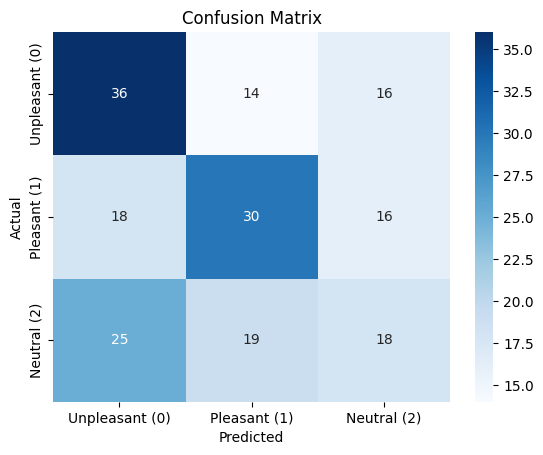

In [38]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Let's assume X_pleasantness and y_pleasantness exist from your previous code.
# X_pleasantness is your dictionary of feature arrays.
# y_pleasantness is your array of labels (0s and 1s).

# --- 1. Combine All Features into a Single Matrix ---
# We must convert the dictionary of arrays into one large 2D array.
# It's good practice to define an order to ensure consistency.
print("Step 1: Combining feature dictionary into a single matrix...")

feature_order = ['degree', 'clustering', 'betweenness', 'local_efficiency']
list_of_feature_arrays = [X_3class[key] for key in feature_order]

# np.concatenate with axis=1 stacks the arrays side-by-side.
X_combined = np.concatenate(list_of_feature_arrays, axis=1)

print(f"Shape of the final feature matrix (X): {X_combined.shape}")
print(f"Shape of the label vector (y): {y_3class.shape}")


# --- 2. Split Data into Training and Testing Sets ---
# This is a critical step for validating the model's performance on unseen data.
print("\nStep 2: Splitting data into training and testing sets...")

X_train, X_test, y_train, y_test = train_test_split(
    X_combined,
    y_3class,
    test_size=0.3,          # Use 30% of data for testing
    random_state=42,        # For reproducible results
    stratify=y_3class # ESSENTIAL for imbalanced data like yours!
)
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")


# --- 3. Scale the Features ---
# SVMs are very sensitive to the scale of features. We must scale them.
# IMPORTANT: Fit the scaler ONLY on the training data to avoid data leakage.
print("\nStep 3: Scaling features...")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) # Use the same scaler to transform the test set
print("Features have been scaled.")


# --- 4. Train the SVM Model ---
# Now we create and train the Support Vector Classifier.
print("\nStep 4: Training the SVM model...")

# Instantiate the model. 'C' is a regularization parameter.
# kernel='rbf' is a good default choice.
svm_model = SVC(kernel='rbf', C=1.0, random_state=42)

# Fit the model on the SCALED training data
svm_model.fit(X_train_scaled, y_train)
print("Model training complete.")


# --- 5. Make Predictions and Evaluate the Model ---
print("\nStep 5: Evaluating the model on the test set...")

# Predict the labels for the (unseen) test data
y_pred = svm_model.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy:.4f}")

# Print a detailed classification report
print("\nClassification Report:")
# The 'target_names' argument makes the report easier to read.
print(classification_report(y_test, y_pred, target_names=['Unpleasant (0)', 'Pleasant (1)', 'Neutral (2)']))


# --- 6. (Optional but Recommended) Visualize the Results ---
print("\nStep 6: Visualizing the confusion matrix...")

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Unpleasant (0)', 'Pleasant (1)', 'Neutral (2)'],
            yticklabels=['Unpleasant (0)', 'Pleasant (1)', 'Neutral (2)'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

Step 1: Combining feature dictionary into a single matrix...
Shape of the final feature matrix (X): (432, 4320)
Shape of the label vector (y): (432,)

Step 2: Splitting data into training and testing sets...
Training set size: 302 samples
Testing set size: 130 samples

Step 3: Scaling features...
Features have been scaled.

Step 4: Training the SVM model...
Model training complete.

Step 5: Evaluating the model on the test set...

Model Accuracy: 0.6308

Classification Report:
                precision    recall  f1-score   support

Unpleasant (0)       0.62      0.71      0.66        66
  Pleasant (1)       0.65      0.55      0.59        64

      accuracy                           0.63       130
     macro avg       0.63      0.63      0.63       130
  weighted avg       0.63      0.63      0.63       130


Step 6: Visualizing the confusion matrix...


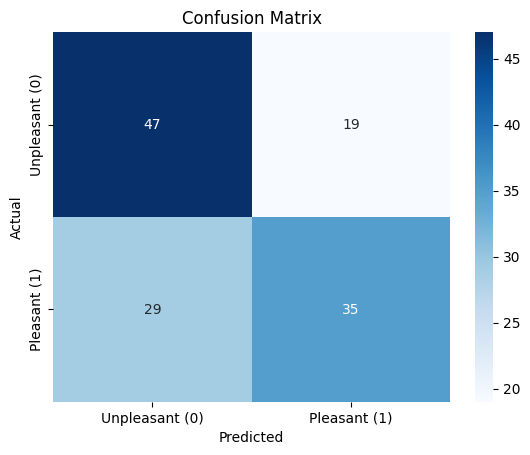

In [53]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Let's assume X_pleasantness and y_pleasantness exist from your previous code.
# X_pleasantness is your dictionary of feature arrays.
# y_pleasantness is your array of labels (0s and 1s).

# --- 1. Combine All Features into a Single Matrix ---
# We must convert the dictionary of arrays into one large 2D array.
# It's good practice to define an order to ensure consistency.
print("Step 1: Combining feature dictionary into a single matrix...")

feature_order = ['degree', 'clustering', 'betweenness', 'local_efficiency']
list_of_feature_arrays = [X_pleasantness[key] for key in feature_order]

# np.concatenate with axis=1 stacks the arrays side-by-side.
X_combined = np.concatenate(list_of_feature_arrays, axis=1)

print(f"Shape of the final feature matrix (X): {X_combined.shape}")
print(f"Shape of the label vector (y): {y_pleasantness.shape}")


# --- 2. Split Data into Training and Testing Sets ---
# This is a critical step for validating the model's performance on unseen data.
print("\nStep 2: Splitting data into training and testing sets...")

X_train, X_test, y_train, y_test = train_test_split(
    X_combined,
    y_pleasantness,
    test_size=0.3,          # Use 30% of data for testing
    random_state=42,        # For reproducible results
    stratify=y_pleasantness # ESSENTIAL for imbalanced data like yours!
)
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")


# --- 3. Scale the Features ---
# SVMs are very sensitive to the scale of features. We must scale them.
# IMPORTANT: Fit the scaler ONLY on the training data to avoid data leakage.
print("\nStep 3: Scaling features...")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) # Use the same scaler to transform the test set
print("Features have been scaled.")


# --- 4. Train the SVM Model ---
# Now we create and train the Support Vector Classifier.
print("\nStep 4: Training the SVM model...")

# Instantiate the model. 'C' is a regularization parameter.
# kernel='rbf' is a good default choice.
svm_model = SVC(kernel='rbf', C=1.0, random_state=42)

# Fit the model on the SCALED training data
svm_model.fit(X_train_scaled, y_train)
print("Model training complete.")


# --- 5. Make Predictions and Evaluate the Model ---
print("\nStep 5: Evaluating the model on the test set...")

# Predict the labels for the (unseen) test data
y_pred = svm_model.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy:.4f}")

# Print a detailed classification report
print("\nClassification Report:")
# The 'target_names' argument makes the report easier to read.
print(classification_report(y_test, y_pred, target_names=['Unpleasant (0)', 'Pleasant (1)']))


# --- 6. (Optional but Recommended) Visualize the Results ---
print("\nStep 6: Visualizing the confusion matrix...")

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Unpleasant (0)', 'Pleasant (1)'],
            yticklabels=['Unpleasant (0)', 'Pleasant (1)'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [39]:
import numpy as np
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyClassifier

# Let's assume X_pleasantness and y_pleasantness exist from your previous code.
# X_pleasantness is your dictionary of feature arrays.
# y_pleasantness is your array of labels (0s and 1s).

# --- 1. Combine All Features into a Single Matrix (Same as before) ---
# LazyPredict needs a single 2D NumPy array for the features.
print("Step 1: Combining feature dictionary into a single matrix...")

feature_order = ['degree', 'clustering', 'betweenness', 'local_efficiency']
list_of_feature_arrays = [X_3class[key] for key in feature_order]
X_combined = np.concatenate(list_of_feature_arrays, axis=1)

print(f"Shape of the final feature matrix (X): {X_combined.shape}")
print(f"Shape of the label vector (y): {y_3class.shape}")


# --- 2. Split Data into Training and Testing Sets ---
# LazyClassifier requires the data to be pre-split into train and test sets.
print("\nStep 2: Splitting data into training and testing sets...")

X_train, X_test, y_train, y_test = train_test_split(
    X_combined,
    y_3class,
    test_size=0.3,
    random_state=42,
    stratify=y_3class # Crucial for your imbalanced data!
)
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")


# --- 3. Run LazyClassifier ---
# This is where the magic happens. We instantiate the classifier and fit it.
print("\nStep 3: Running LazyPredict to evaluate all models...")

# verbose=0 suppresses the output of every single model fitting.
# ignore_warnings=True cleans up the output from various library version conflicts.
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)

# The .fit() method returns a tuple of (models, predictions)
# We are most interested in the 'models' DataFrame.
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

print("\n--- LazyPredict Results ---")
print(models)

Step 1: Combining feature dictionary into a single matrix...
Shape of the final feature matrix (X): (640, 4320)
Shape of the label vector (y): (640,)

Step 2: Splitting data into training and testing sets...
Training set size: 448 samples
Testing set size: 192 samples

Step 3: Running LazyPredict to evaluate all models...


 97%|█████████▋| 30/31 [00:31<00:02,  2.32s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 318197
[LightGBM] [Info] Number of data points in the train set: 448, number of used features: 4312
[LightGBM] [Info] Start training from score -1.067841
[LightGBM] [Info] Start training from score -1.107581
[LightGBM] [Info] Start training from score -1.121187
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

100%|██████████| 31/31 [00:36<00:00,  1.17s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

--- LazyPredict Results ---
                               Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                          
LGBMClassifier                     0.47               0.47    None      0.47   
GaussianNB                         0.46               0.46    None      0.46   
SVC                                0.44               0.43    None      0.43   
NuSVC                              0.43       

In [29]:
X_combined

array([[1.        , 6.        , 0.        , ..., 0.95887446, 0.96103896,
        0.96320346],
       [4.        , 4.        , 3.        , ..., 0.96320346, 0.9486166 ,
        0.95652174],
       [3.        , 5.        , 2.        , ..., 0.96428571, 0.9486166 ,
        0.96190476],
       ...,
       [1.        , 2.        , 0.        , ..., 0.95652174, 0.95670996,
        0.95454545],
       [1.        , 2.        , 2.        , ..., 0.95454545, 0.96315789,
        0.95059289],
       [1.        , 1.        , 0.        , ..., 0.95059289, 0.94664032,
        0.95670996]])

In [42]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyClassifier

# Let's assume X_pleasantness (the dictionary of arrays) and y_pleasantness exist.

# --- 1. Create the Aggregated 4-Column DataFrame ---
print("Step 1: Aggregating detailed features into a 4-column DataFrame...")

# For each feature type, we will calculate the mean across all its detailed features.
# The result will be a single number per trial for each type.
aggregated_data = {
    # np.mean(X, axis=1) calculates the mean for each row (sample).
    'degree': np.mean(X_3class['degree'], axis=1),
    'clustering': np.mean(X_3class['clustering'], axis=1),
    'betweenness': np.mean(X_3class['betweenness'], axis=1),
    'local_efficiency': np.mean(X_3class['local_efficiency'], axis=1)
}

# Now, create the pandas DataFrame from this dictionary.
X_aggregated_df = pd.DataFrame(aggregated_data)
X_aggregated_df.drop(columns=['degree'], inplace=True)

print("\n--- Aggregated DataFrame ---")
print("Shape of the new DataFrame:", X_aggregated_df.shape)
print("First 5 rows:")
print(X_aggregated_df.head())


# --- 2. Split Data into Training and Testing Sets ---
# We use the new DataFrame as our feature set.
print("\nStep 2: Splitting the aggregated data for LazyPredict...")
X_train, X_test, y_train, y_test = train_test_split(
    X_aggregated_df,  # Using our new 4-column DataFrame
    y_3class,
    test_size=0.3,
    random_state=42,
    stratify=y_3class
)


# --- 3. Run LazyClassifier on the Aggregated Data ---
print("\nStep 3: Running LazyPredict on the 4-column DataFrame...")
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

print("\n--- LazyPredict Results (using 4 aggregated features) ---")
print(models)

Step 1: Aggregating detailed features into a 4-column DataFrame...

--- Aggregated DataFrame ---
Shape of the new DataFrame: (640, 3)
First 5 rows:
   clustering  betweenness  local_efficiency
0        0.64         0.02              0.84
1        0.63         0.02              0.84
2        0.63         0.02              0.85
3        0.63         0.02              0.85
4        0.66         0.02              0.84

Step 2: Splitting the aggregated data for LazyPredict...

Step 3: Running LazyPredict on the 4-column DataFrame...


100%|██████████| 31/31 [00:01<00:00, 29.88it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,000074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 450
[LightGBM] [Info] Number of data points in the train set: 448, number of used features: 3
[LightGBM] [Info] Start training from score -1,067841
[LightGBM] [Info] Start training from score -1,107581
[LightGBM] [Info] Start training from score -1,121187
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

In [45]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from lazypredict.Supervised import LazyClassifier

# Let's assume X_3class and y_3class exist from your previous code.

# --- 1. Create the Aggregated DataFrame ---
print("Step 1: Aggregating detailed features into a DataFrame...")
aggregated_data = {
    'degree': np.mean(X_3class['degree'], axis=1),
    'clustering': np.mean(X_3class['clustering'], axis=1),
    'betweenness': np.mean(X_3class['betweenness'], axis=1),
    'local_efficiency': np.mean(X_3class['local_efficiency'], axis=1)
}
X_aggregated_df = pd.DataFrame(aggregated_data)
# Let's use all 4 features for creating interactions. If you want to drop one, do it here.
X_aggregated_df.drop(columns=['degree'], inplace=True)

print("\n--- Aggregated DataFrame ---")
print("Shape of the initial DataFrame:", X_aggregated_df.shape)
print(X_aggregated_df.head())


# --- 2. Split Data into Training and Testing Sets ---
print("\nStep 2: Splitting the aggregated data...")
X_train, X_test, y_train, y_test = train_test_split(
    X_aggregated_df,
    y_3class,
    test_size=0.3,
    random_state=42,
    stratify=y_3class
)


## --- NEW STEP 3: Feature Engineering and Scaling --- ##
print("\nStep 3: Applying PolynomialFeatures and StandardScaler...")

# Initialize the preprocessors
# degree=2 will create original features, interaction terms (a*b), and squared terms (a^2)
poly = PolynomialFeatures(degree=3, include_bias=False)
scaler = StandardScaler()

# --- Fit and transform the TRAINING data ---
# This learns the transformations and applies them
X_train_poly = poly.fit_transform(X_train)
X_train_final = scaler.fit_transform(X_train_poly)

# --- ONLY transform the TESTING data ---
# This applies the SAME transformations learned from the training data
X_test_poly = poly.transform(X_test)
X_test_final = scaler.transform(X_test_poly)

print(f"Original number of features: {X_train.shape[1]}")
print(f"Number of features after PolynomialFeatures: {X_train_final.shape[1]}")


# --- 4. Run LazyClassifier on the NEW, Engineered Data ---
print("\nStep 4: Running LazyPredict on engineered and scaled features...")
# Use the final transformed data
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train_final, X_test_final, y_train, y_test)

print("\n--- LazyPredict Results (using Polynomial & Scaled features) ---")
print(models)

Step 1: Aggregating detailed features into a DataFrame...

--- Aggregated DataFrame ---
Shape of the initial DataFrame: (640, 3)
   clustering  betweenness  local_efficiency
0        0.64         0.02              0.84
1        0.63         0.02              0.84
2        0.63         0.02              0.85
3        0.63         0.02              0.85
4        0.66         0.02              0.84

Step 2: Splitting the aggregated data...

Step 3: Applying PolynomialFeatures and StandardScaler...
Original number of features: 3
Number of features after PolynomialFeatures: 19

Step 4: Running LazyPredict on engineered and scaled features...


100%|██████████| 31/31 [00:01<00:00, 25.99it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,000138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2843
[LightGBM] [Info] Number of data points in the train set: 448, number of used features: 19
[LightGBM] [Info] Start training from score -1,067841
[LightGBM] [Info] Start training from score -1,107581
[LightGBM] [Info] Start training from score -1,121187
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

In [40]:
X_aggregated_df

,degree,clustering,betweenness,local_efficiency
0,11.52,0.64,0.02,0.84
1,11.52,0.63,0.02,0.84
2,11.52,0.63,0.02,0.85
3,11.52,0.63,0.02,0.85
4,11.52,0.66,0.02,0.84
...,...,...,...,...
427,11.52,0.64,0.02,0.84
428,11.52,0.63,0.02,0.84
429,11.52,0.63,0.03,0.85
430,11.52,0.63,0.02,0.85
